In [1]:
import os
import time
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.optim import AdamW

# ✅ Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Using device:", device)

# ✅ Dataset
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )
        input_ids = encodings['input_ids'].squeeze()
        attention_mask = encodings['attention_mask'].squeeze()
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }


# ✅ Model class
class FakeNewsClassifier:
    def __init__(self):
        print("📦 Initializing BERT model")
        self.model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
        self.model.to(device)

    def train(self, train_loader, val_loader, epochs=6, learning_rate=2e-5):
        print(f"🔁 Starting training for {epochs} epochs...")
        optimizer = AdamW(self.model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        use_amp = device.type == 'cuda'
        scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

        self.model.train()

        for epoch in range(epochs):
            total_loss = 0
            for batch in train_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                optimizer.zero_grad()
                with torch.amp.autocast(device_type=device.type, enabled=use_amp):
                    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                    loss = criterion(outputs.logits, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                total_loss += loss.item()
            print(f"📉 Epoch {epoch + 1} - Loss: {total_loss:.4f}")

            # Validation
            self.model.eval()
            val_preds, val_labels = [], []
            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['label'].to(device)

                    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                    preds = torch.argmax(outputs.logits, dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

            val_acc = accuracy_score(val_labels, val_preds)
            print(f"✅ Validation Accuracy after Epoch {epoch + 1}: {val_acc:.4f}")
            self.model.train()

    def save(self, path='bert_fakenews1.pt'):
        torch.save(self.model.state_dict(), path)
        print(f"✅ Model saved to {path}")

    def load(self, path='bert_fakenews1.pt'):
        self.model.load_state_dict(torch.load(path, map_location=device))
        self.model.to(device)
        print(f"✅ Model loaded from {path}")

    def predict(self, text_list):
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model.eval()
        results = []
        with torch.no_grad():
            for text in text_list:
                enc = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
                input_ids = enc['input_ids'].to(device)
                attention_mask = enc['attention_mask'].to(device)
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                prediction = torch.argmax(outputs.logits, dim=1).item()
                results.append(prediction)
        return results


# ✅ Training utility
def train_bert_model(fake_csv, true_csv, force_retrain=False):
    model_path = 'bert_fakenews1.pt'
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    classifier = FakeNewsClassifier()

    if os.path.exists(model_path) and not force_retrain:
        print("📂 Using existing trained model...")
        classifier.load(model_path)
        return classifier

    print("📊 Preparing dataset...")
    fake_df = pd.read_csv(fake_csv)
    true_df = pd.read_csv(true_csv)

    fake_df['label'] = 0
    true_df['label'] = 1
    data = pd.concat([fake_df, true_df]).sample(frac=1).reset_index(drop=True)

    # Extra examples
    extra_texts = [
        "BREAKING: Earth now flat, scientists apologize.",
        "Study shows eating rocks improves digestion.",
        "Aliens are attacking on Earth",
        "NASA confirms Mars is actually made of cheese.",
        "The sun rises in the east and sets in the west.",
        "Water found to be wet after extensive study.",
        "Aliens endorse presidential candidate in spoof ad.",
        "Virat Kohli is the greatest batsman.",
        "Moon declared a new state by Elon Musk",
        "Earth orbits the sun, confirms NASA",
        "Water boils at 100 degrees Celsius under standard pressure",
        "UN announces climate summit for 2025",
        "COVID-19 vaccine proven safe and effective by CDC",
        "Mount Everest remains tallest mountain, scientists say",
        "Apple releases latest iPhone with improved battery life",
        "India wins historic test match at Lord’s",
        "World Health Organization outlines pandemic preparedness plan",
        "Google updates Android OS with new features",
        "NASA's James Webb telescope captures deepest universe image",
        "Aliens land in New York to endorse political candidate",
        "Bill Gates implants 5G chips via vaccines, claims YouTube expert",
        "NASA confirms Earth is flat in shocking new report",
        "Politicians unanimously decide to never lie again",
        "The Onion: Mars declares independence from Earth",
        "Dinosaurs spotted alive in Amazon rainforest",
        "Elon Musk buys the moon to build Tesla colony",
        "Drinking bleach cures COVID-19, viral post claims",
        "Government replaces birds with surveillance drones",
        "Study shows thinking makes you invisible",
        "India is a powerful country."
    ]
    extra_labels = [0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,1]

    extra_df = pd.DataFrame({'title': extra_texts, 'label': extra_labels})
    data = pd.concat([data, extra_df], ignore_index=True)

    texts = data['title'].astype(str).tolist()
    labels = data['label'].tolist()

    X_train, X_test, y_train, y_test = train_test_split(
        texts, labels, test_size=0.2, random_state=42, stratify=labels
    )

    train_dataset = NewsDataset(X_train, y_train, tokenizer)
    val_dataset = NewsDataset(X_test, y_test, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)

    start = time.time()
    classifier.train(train_loader, val_loader, epochs=6, learning_rate=2e-5)
    classifier.save(model_path)
    end = time.time()
    print(f"⏱️ Training completed in {end - start:.2f} seconds")

    return classifier


# ✅ Main
if __name__ == "__main__":
    classifier = train_bert_model(
        '/kaggle/input/fake-news/Fake.csv',
        '/kaggle/input/fake-news/True.csv',
        force_retrain=True
    )

    # 🔍 Sample prediction
    sample_texts = [
        "Donald Trump just won the election!",
        "Aliens have landed in New York City!",
        "Pfizer's COVID-19 vaccine is now approved by the WHO."
    ]
    predictions = classifier.predict(sample_texts)
    for text, label in zip(sample_texts, predictions):
        print(f"📰 \"{text}\" → {'REAL' if label == 1 else 'FAKE'}")


2025-06-02 03:25:52.191652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748834752.369504      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748834752.421915      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🖥️ Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

📦 Initializing BERT model


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Preparing dataset...
🔁 Starting training for 6 epochs...


/tmp/ipykernel_35/3634510550.py:57: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


📉 Epoch 1 - Loss: 315.7952
✅ Validation Accuracy after Epoch 1: 0.9841
📉 Epoch 2 - Loss: 113.3342
✅ Validation Accuracy after Epoch 2: 0.9873
📉 Epoch 3 - Loss: 57.9741
✅ Validation Accuracy after Epoch 3: 0.9854
📉 Epoch 4 - Loss: 35.6530
✅ Validation Accuracy after Epoch 4: 0.9863
📉 Epoch 5 - Loss: 22.6954
✅ Validation Accuracy after Epoch 5: 0.9871
📉 Epoch 6 - Loss: 27.3226
✅ Validation Accuracy after Epoch 6: 0.9871
✅ Model saved to bert_fakenews1.pt
⏱️ Training completed in 12043.70 seconds
📰 "Donald Trump just won the election!" → FAKE
📰 "Aliens have landed in New York City!" → FAKE
📰 "Pfizer's COVID-19 vaccine is now approved by the WHO." → REAL


# FOR TESTING

In [2]:
import torch
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Dataset class
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            'input_ids': encodings['input_ids'].squeeze(),
            'attention_mask': encodings['attention_mask'].squeeze(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Load saved model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.load_state_dict(torch.load("bert_fakenews1.pt", map_location=device))
model.to(device)
model.eval()

# Load data again
fake_df = pd.read_csv('/kaggle/input/fake-news/Fake.csv')
true_df = pd.read_csv('/kaggle/input/fake-news/True.csv')
fake_df['label'] = 0
true_df['label'] = 1
data = pd.concat([fake_df, true_df]).sample(frac=1).reset_index(drop=True)

# Small test set
test_data = data.sample(n=300)
texts = test_data['title'].astype(str).tolist()
labels = test_data['label'].tolist()

# Tokenizer and dataset
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
test_dataset = NewsDataset(texts, labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=8)

# Prediction
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Report
print("✅ Classification Report:\n", classification_report(true_labels, predictions))
print("📊 Confusion Matrix:\n", confusion_matrix(true_labels, predictions))


Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       149
           1       1.00      1.00      1.00       151

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

📊 Confusion Matrix:
 [[149   0]
 [  0 151]]


In [4]:
import pandas as pd

# Load the data
fake_df = pd.read_csv('/kaggle/input/fake-news/Fake.csv')
true_df = pd.read_csv('/kaggle/input/fake-news/True.csv')

# Add labels
fake_df['label'] = 0
true_df['label'] = 1

# Combine and shuffle
data = pd.concat([fake_df, true_df]).sample(frac=1).reset_index(drop=True)

# Show class balance
print("✅ Class distribution:\n", data['label'].value_counts())


✅ Class distribution:
 label
0    23481
1    21417
Name: count, dtype: int64


In [5]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# ✅ Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.load_state_dict(torch.load("/kaggle/working/bert_fakenews1.pt", map_location=device))
model.to(device)
model.eval()

# ✅ Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# ✅ Sample predictions
def predict(texts):
    results = []
    with torch.no_grad():
        for text in texts:
            encoding = tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=512)
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            output = model(input_ids=input_ids, attention_mask=attention_mask)
            pred = torch.argmax(output.logits, dim=1).item()
            results.append("REAL" if pred == 1 else "FAKE")
    return results

# 🔍 Test samples
sample_texts = [
    "Biden signs historic climate deal.",
    "NASA finds aliens living on Jupiter's moon!",
    "COVID vaccine causes people to grow tails.",
    "Stock market hits record highs amid tech boom.",
    "Aliens attack on Earth, 1 million people killed.",
    "World War 4 is happening , India and USA have joined hands.",
    "Prime Minister Narendra Modi kicks USA President Donald Trump on his face.",
    "Earth revolves around the Sun.",
    
]

results = predict(sample_texts)
for text, label in zip(sample_texts, results):
    print(f"📰 \"{text}\" → {label}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📰 "Biden signs historic climate deal." → REAL
📰 "NASA finds aliens living on Jupiter's moon!" → REAL
📰 "COVID vaccine causes people to grow tails." → FAKE
📰 "Stock market hits record highs amid tech boom." → REAL
📰 "Aliens attack on Earth, 1 million people killed." → FAKE
📰 "World War 4 is happening , India and USA have joined hands." → FAKE
📰 "Prime Minister Narendra Modi kicks USA President Donald Trump on his face." → FAKE
📰 "Earth revolves around the Sun." → REAL


In [8]:
sample_news = [
    "Scientists discover cure for cancer in 24 hours!",
    "Elon Musk buys the Moon and plans to build a city.",
    "The government announced a new education policy to promote AI learning in schools.",
    "Aliens have taken over the White House!",
    "WHO confirms the eradication of malaria worldwide.",
    "Kanye West declares himself the new Pope.",
    "India successfully launches its first manned mission to Mars.",
    "Facebook will start charging users $5 per month to use the platform.",
    "NASA confirms Earth is flat in shocking report!",
    "Apple releases iPhone 20 with holographic screen and teleportation."
]

results = predict(sample_news)
for text, label in zip(sample_news, results):
    print(f"📰 \"{text}\" → {label}")


📰 "Scientists discover cure for cancer in 24 hours!" → FAKE
📰 "Elon Musk buys the Moon and plans to build a city." → FAKE
📰 "The government announced a new education policy to promote AI learning in schools." → FAKE
📰 "Aliens have taken over the White House!" → FAKE
📰 "WHO confirms the eradication of malaria worldwide." → REAL
📰 "Kanye West declares himself the new Pope." → REAL
📰 "India successfully launches its first manned mission to Mars." → REAL
📰 "Facebook will start charging users $5 per month to use the platform." → FAKE
📰 "NASA confirms Earth is flat in shocking report!" → FAKE
📰 "Apple releases iPhone 20 with holographic screen and teleportation." → REAL


In [9]:
sample_news = [
    "India to host Global AI Summit 2025 in Bengaluru.",
    "Government plans to replace teachers with AI robots in all schools by 2026.",
    "NASA discovers Earth-like planet with signs of life 500 light-years away.",
    "Amazon to open its first space warehouse on the Moon.",
    "RBI launches digital rupee pilot program in select cities.",
    "Google introduces chip implant to replace smartphones by 2026.",
    "WHO issues warning on new fast-spreading respiratory virus.",
    "Microsoft merges with Tesla to create world’s first AI-car company.",
    "Supreme Court mandates AI audit for all social media platforms in India.",
    "Scientists revive 10,000-year-old virus from Siberian ice."
]

results = predict(sample_news)
for text, label in zip(sample_news, results):
    print(f"📰 \"{text}\" → {label}")

📰 "India to host Global AI Summit 2025 in Bengaluru." → REAL
📰 "Government plans to replace teachers with AI robots in all schools by 2026." → FAKE
📰 "NASA discovers Earth-like planet with signs of life 500 light-years away." → FAKE
📰 "Amazon to open its first space warehouse on the Moon." → FAKE
📰 "RBI launches digital rupee pilot program in select cities." → REAL
📰 "Google introduces chip implant to replace smartphones by 2026." → REAL
📰 "WHO issues warning on new fast-spreading respiratory virus." → REAL
📰 "Microsoft merges with Tesla to create world’s first AI-car company." → FAKE
📰 "Supreme Court mandates AI audit for all social media platforms in India." → REAL
📰 "Scientists revive 10,000-year-old virus from Siberian ice." → REAL


# PLOTTING

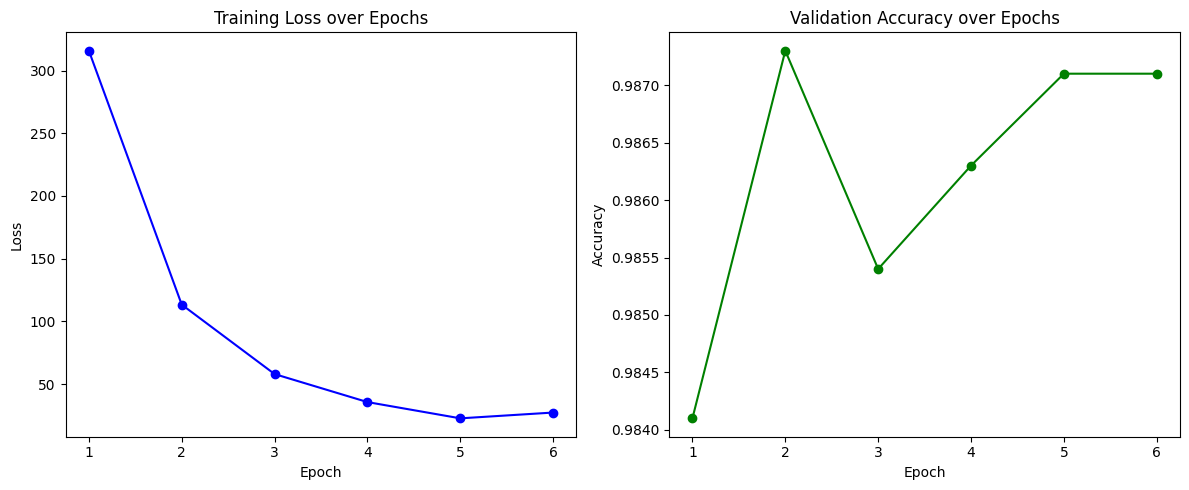

In [6]:
import matplotlib.pyplot as plt

# Use the values from your training logs:
losses = [315.7952, 113.3342, 57.9741, 35.6530, 22.6954, 27.3226]
accuracies = [0.9841, 0.9873, 0.9854, 0.9863, 0.9871, 0.9871]
epochs = range(1, len(losses) + 1)

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, marker='o', color='blue')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, marker='o', color='green')
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()
